# **--- Análisis de posibles empresas cerca de la bancarrota ---**

## Introduccion
En este proyecto se analizara un dataset que contiene un listado de 6000 empresas que estan acotadas con 95 columnas de indices economicos diferentes, ademas este dataset tiene la particularidad de poseer algunas empresas que se nos indica que ya no estan operativas porque cayeron en bancarrota. 

## Objetivos
Nuestro objetivo principal es crear un algortimo de machine learning que nos permita identificar a travez de la entrada de datos si una empresa posee indices economicos que podrian indicar que corre peligro de quebrar. No obstante para que el algoritmo sea lo mas eficiente y practico posible debemos reducir las 95 variables diferentes a un numero menor sacrificando la menor presicion posible.

## Proposito
El propósito de nuestro proyecto puede verse desde dos perspectivas diferentes, una es del lado de un inversor, el cual busca o corrobora que la empresa a la que va a invertir o esta invertido no este en cercanía a declararse en la quiebra, perdiendo su dinero en el proceso. Y la otra perspectiva es la de un empresario que quiere comparar sus datos económicos con otras empresas para saber cual es el estado financiero de su compañía o el de la competencia para elaborar un plan de toma de decisiones en base a los resultados obtenidos. 

In [11]:
# Librerias
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix , classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Dataset
CBP = pd.read_csv('https://media.githubusercontent.com/media/Gonzalo-Ariel-Alonso/Proyecto_Data_Science/master/Company%20Bankruptcy%20Prediction.csv')
CBP

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


# Etapa 1: Escalado de datos y reduccion de variables

### Escalado de datos
Para evitar cualquier tipo de sesgo numerico por la diferencia de dimenciones, llevamos todos los datos a la misma escala.

In [4]:
# Escalado de datos
from sklearn.preprocessing import MinMaxScaler as MMS
scaler = MMS()
CBP_scaled = scaler.fit_transform(CBP)
CBP_scaled = pd.DataFrame(CBP_scaled, columns = list(CBP.columns))

### Matriz de Correlacion 
Para lograr reducir la cantidad de variables utilizaremos un metodo simple pero practico: analizaremos la relacion de cada variable con la columna de "Bankrupt?", de esta manera poderemos filtrar las variables con mas correlacion positiva y negativa y analizarlas para corroborar que si pueden llegar a estar relacionadas con la bancarrota de una empresa.

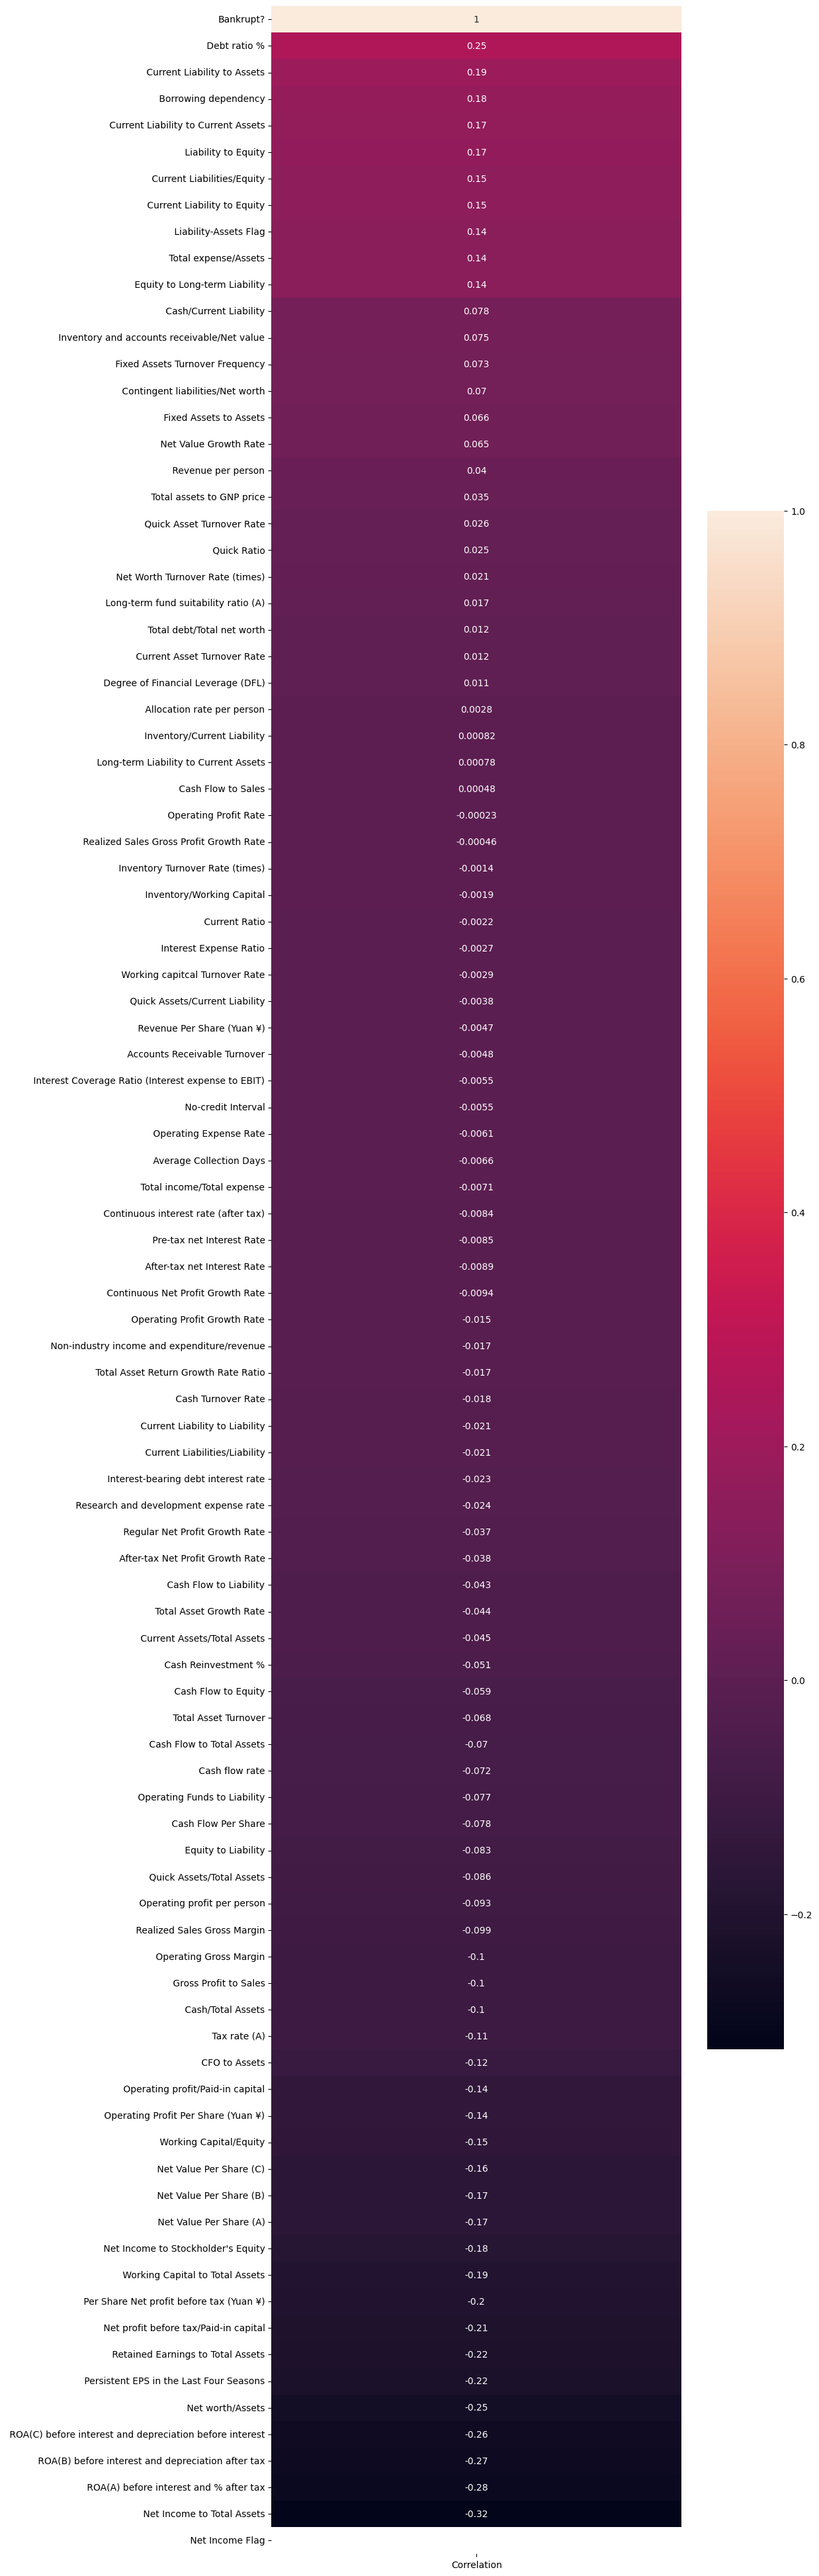

In [6]:
correlation_with_bankrupt = CBP.corrwith(CBP.iloc[:,0]).sort_values(ascending = False)
corr_df = pd.DataFrame(correlation_with_bankrupt , columns=['Correlation'])
plt.figure(figsize = (10,50))
sns.heatmap(data = corr_df, annot = True)
plt.show()

De esta grafica tomaremos las 3 variables con mayor correlacion positiva:
 - Debt ratio %
 - Current liability to assets
 - Borrowing dependecy
 
Y como tenemos mayor cantidad de variables con mayor correlacion negativa tomaremos 5 variables y ultilizaremos solo un ROA:
 - Net Income to Total Assets
 - ROA(A) before interest and % after tax
 - Net Worth/Assets
 - Persistent EPS in the Last Four Seasons
 - Retained Earnings to Total Assets

# Etapa 2: Analisis exploratorio de los datos  (EDA)
Ahora que redujimos la cantidad de dimencioens de 95 a 8, podemos tomarnos el trabajo de analizar cada variable en profundidad para conocer que reprecenta y que tan significativa es con la bancarrota de una empresa.

## *Variables con correlacion positiva*

##  Debt ratio %

El índice Debt ratio se calcula dividiendo todos los pasivos sobre los activos de una empresa. Cuanto mayor sea el porcentaje, mayor será el nivel de endeudamiento en relación con sus activos. 
Comparemos el rango de valores que toma el debt ratio de las empresas en bancarota con las operativas.

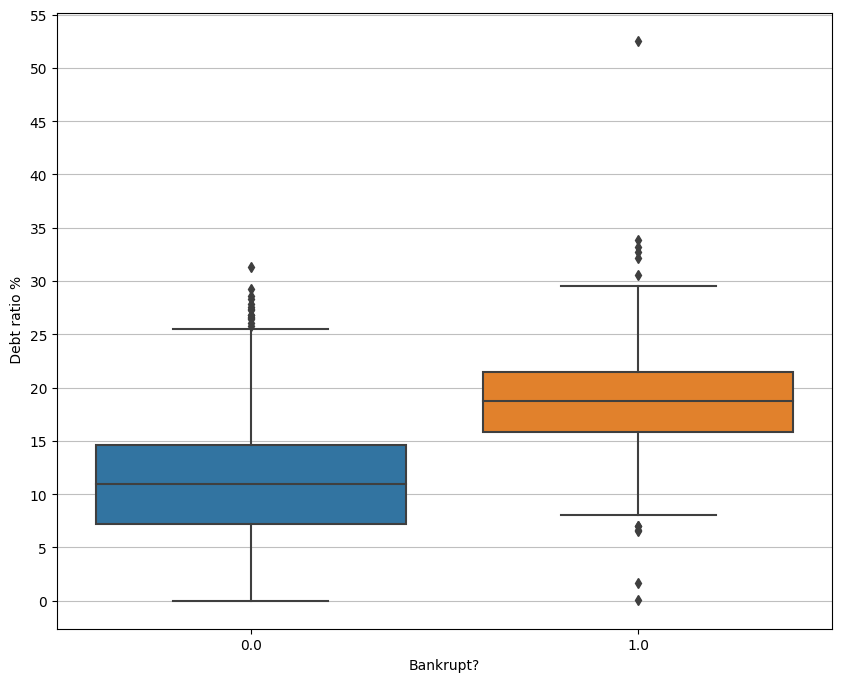

In [12]:
debt_ratio = CBP_scaled[CBP_scaled.iloc[:,37] < 1].iloc[:,[0,37]]

plt.figure(figsize = (10,8))

graph = sns.boxplot(x =debt_ratio['Bankrupt?'], y = debt_ratio[' Debt ratio %'] * 100)
graph.set_axisbelow(True)
graph.set_yticks(np.arange(0,56,5))

plt.grid(axis = 'y', alpha = 0.8)
plt.show()

Como podemos observar, existe una clara diferencia de la media del debt ratio entre las companias operativas contra las que entraron en bancarrota, esto nos da indicio de que aquellas companias que tiene un porcentaje de debt ratio superior al %15 estan demasiado endeudadas y son mas propensas a quebrar.

## Current Liability to Assets
Este indice se calcula dividiendo la deuda corriente (deuda a corto plaso) sobre los activos totales. Comparemos el indice con las companias operativas y en bancarrota.

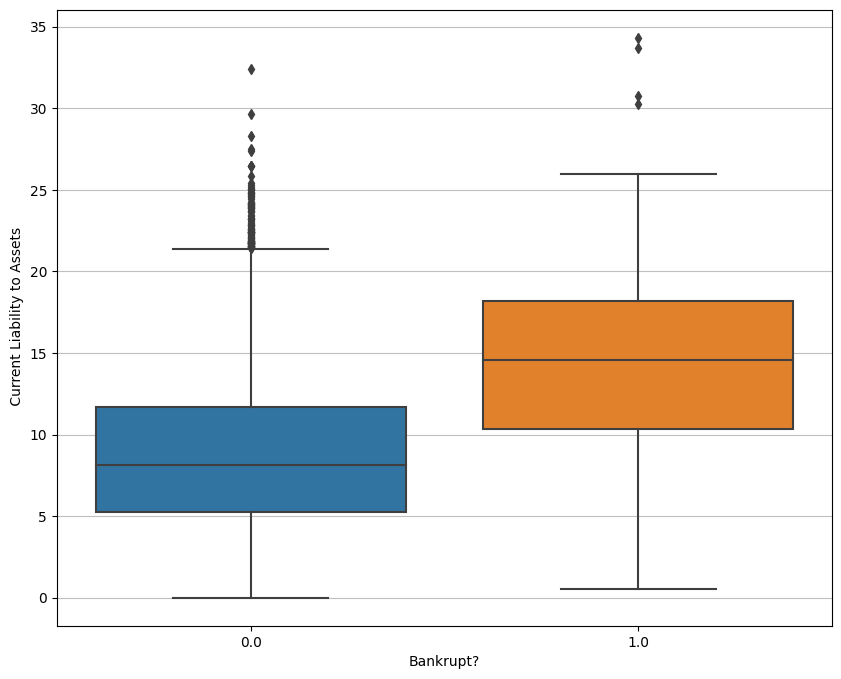

In [13]:
current_liability = CBP_scaled[CBP_scaled.iloc[:,60] < 1].iloc[:,[0,60]]

plt.figure(figsize = (10,8))

graph = sns.boxplot(x =current_liability['Bankrupt?'], y = current_liability[' Current Liability to Assets'] * 100)
graph.set_axisbelow(True)
graph.set_yticks(np.arange(0,36,5))

plt.grid(axis = 'y', alpha = 0.8)
plt.show()

En este caso la diferencia es un poco mas sutil ya que el cuartil alto de las empresas operativas se superpone con el cuartil bajo de las empresas en bancarrota entre el %10 y %12. No obstante sigue habiendo una diferencia notable, aquellas empresas que tiene demasiadas deudas a corto plazo en comparacion a sus activos tiene mas riesgo de quebrar.

## Borrowing dependecy
Nuevamente otro indice de deuda, en este caso definido como cuánto depende una empresa de la deuda con intereses para financiar sus actividades. Si la deuda tomada tiene un interes variable, y las tazas de interes suben la empresa se vera en desventaja, por el contrario si la taza de interes baja sera el acredor el que sufra las concecuencias.

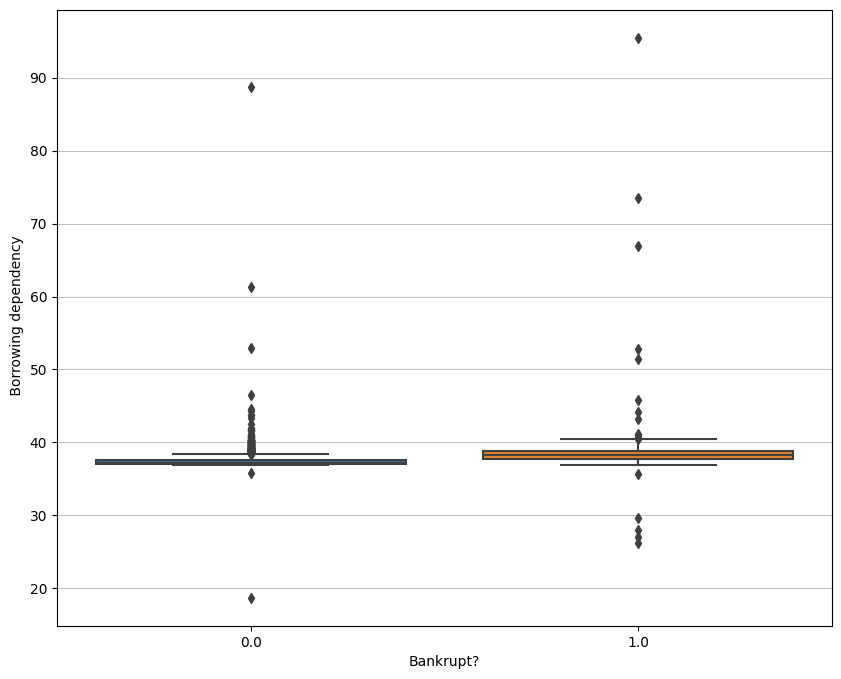

In [15]:
borrowing_dependecy = CBP_scaled[(CBP_scaled.iloc[:,40] > 0) & (CBP.iloc[:,40] < 1)].iloc[:,[0,40]]

plt.figure(figsize = (10,8))

graph = sns.boxplot(x =borrowing_dependecy['Bankrupt?'], y = borrowing_dependecy[' Borrowing dependency'] * 100)
graph.set_axisbelow(True)

plt.grid(axis = 'y', alpha = 0.8)
plt.show()

En este caso las diferencia del indice de Borrowing dependecy entre las companias que estan operativas y las que estan en bancarrota ya no son notorias,ademas de que ambas columnas poseen medias y percentiles demasiado comprimidos, por lo tanto no hay evidencia suficiente para asumir que el indice de Borrowing dependecy tiene un impacto directo importante sobre las posiblidades de que una empresa quiebre asi que **no utilizaremos este indicador**.

## *Variables con correlacion Negativa*

## Net Income to Total Assets
El Net Income to Total Assets es un índice financiero que mide la rentabilidad de una empresa en relación con sus activos totales. Este indicador proporciona una medida de la eficiencia con la que una empresa utiliza sus activos para generar beneficios netos.Se calcula dividiendo los ingresos netos(ingresos después de deducir los gastos, impuestos y otros costos) sobre los activos totales (incluyendo activos corrientes y no corrientes).

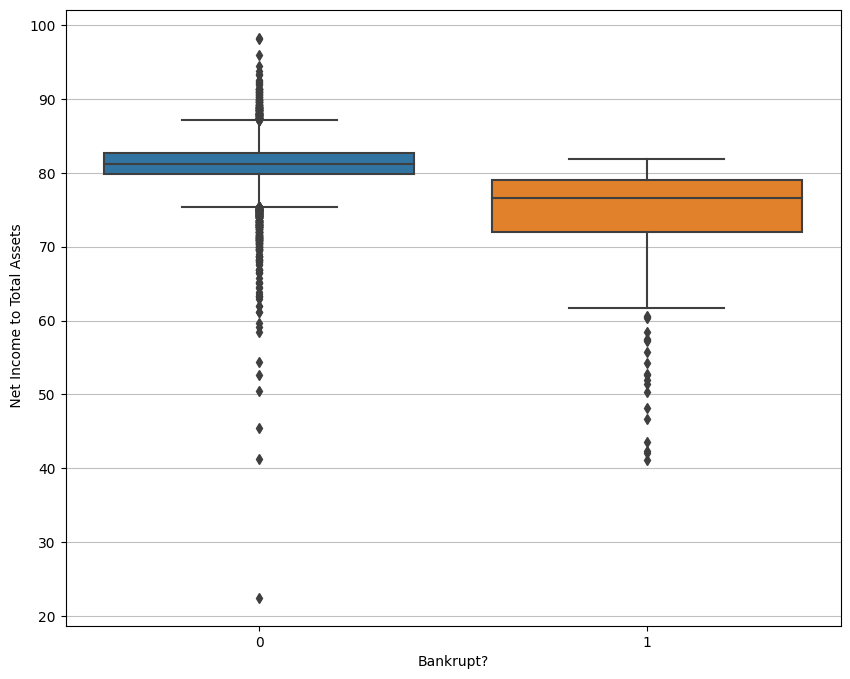

In [16]:
net_income_to_total_assets = CBP[(CBP.iloc[:,86] > 0) & (CBP.iloc[:,86] < 1)].iloc[:,[0,86]]

plt.figure(figsize = (10,8))

graph = sns.boxplot(x =net_income_to_total_assets['Bankrupt?'], 
                    y = net_income_to_total_assets[' Net Income to Total Assets'] * 100)
graph.set_axisbelow(True)

plt.grid(axis = 'y', alpha = 0.8)
plt.show()

Podemos observar que la la mayoria de las empresas que cayeron en bancarrota tenian un indice de rentabilidad menor al 80%. Cabe destacar que por la parte de empresas operativas tenemos un numero alto de outliers.


## ROA(A) before interest and % after tax
Return on Assets before interest and after tax es un indicador financiero que se utiliza para evaluar la rentabilidad de una empresa en relación con sus activos. Este índice calcula la capacidad de la empresa para generar beneficios antes de intereses y después de impuestos en relación con sus activos totales. Este indice tiene en cuenta los impuestos, los cuales varian enormemente seguno la region y el rubro de la empresa.
De los 3 ROAs disponibles es el que mas correlacion (negativa) tiene con las empresas que entraron en bancarrota de nuestro dataset.
 

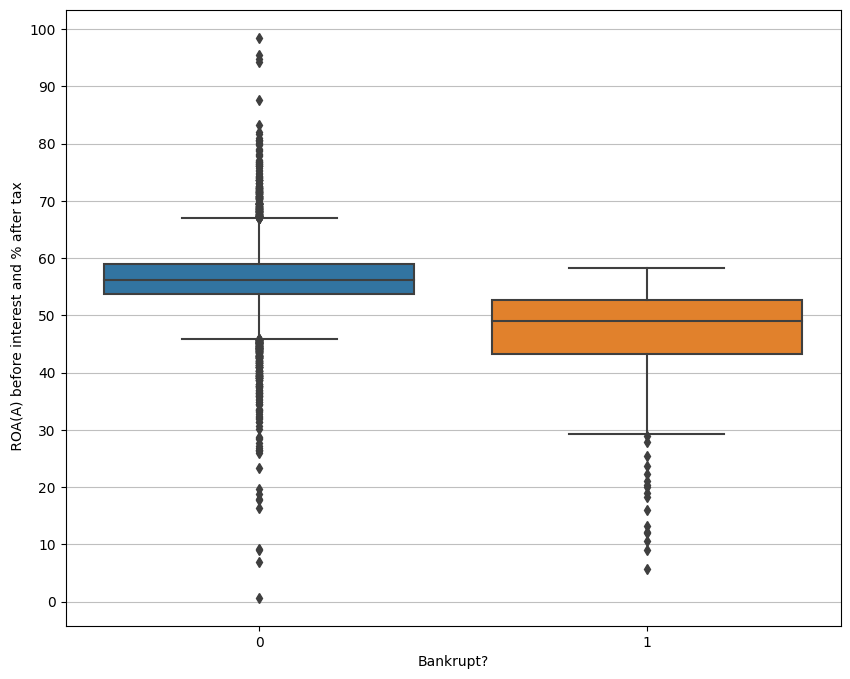

In [17]:
ROA_A = CBP[(CBP.iloc[:,2] > 0) & (CBP.iloc[:,2] < 1)].iloc[:,[0,2]]

plt.figure(figsize = (10,8))

graph = sns.boxplot(x =ROA_A ['Bankrupt?'], 
                    y = ROA_A [' ROA(A) before interest and % after tax'] * 100)
graph.set_axisbelow(True)
graph.set_yticks(np.arange(0,101,10))

plt.grid(axis = 'y', alpha = 0.8)

plt.show()

Podemos observar que no existe ninguna empresa que haya caido en bancarrota tiene un ROA(A) superior al 60% y la mayor concentracion del procentaje de ROA(A) de las empresas en quebradas ronda el 49%.

## Net Worth/Assets
Net Worth/Assets, también conocido como Equity Ratio o Proprietary Ratio, es un índice financiero que se utiliza para evaluar la proporción de los recursos propios de una empresa en relación con sus activos totales. Este indicador proporciona información sobre la solidez financiera y el grado de propiedad de los activos de una empresa.

En esta fórmula, "Net Worth" (Patrimonio Neto) representa los recursos propios de una empresa, que es la diferencia entre los activos y los pasivos. "Total Assets" (Activos Totales) es el valor total de todos los activos de la empresa, incluyendo activos corrientes y no corrientes.

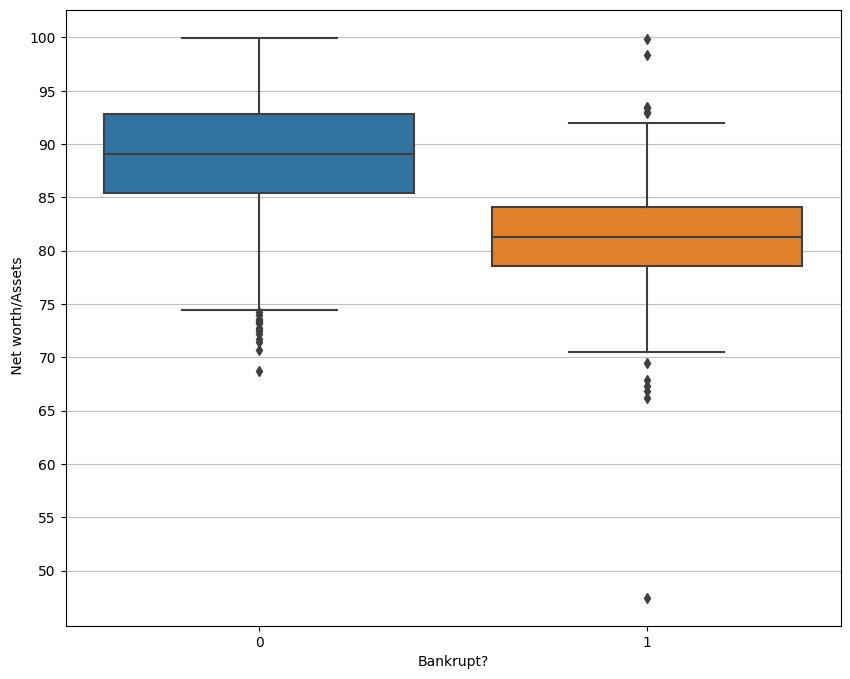

In [18]:
NetWorth_Assets = CBP[(CBP.iloc[:,38] > 0) & (CBP.iloc[:,38] < 1)].iloc[:,[0,38]]

plt.figure(figsize = (10,8))

graph = sns.boxplot(x = NetWorth_Assets['Bankrupt?'], y = NetWorth_Assets[' Net worth/Assets'] * 100)
graph.set_axisbelow(True)
graph.set_yticks(np.arange(50,101,5))

plt.grid(axis = 'y', alpha = 0.8)

plt.show()

Podemos observar que la linea que marca el 85% divide por muy pocos puntos el cuaril inferior de las companias operativas con el cuartil superior de las companias en bancarrota, por lo tanto podemos asumir que un Net Worth/Assets inferior al 85% ya es una señal de peligro en los indicadores de una empresa.

## Persistent EPS in the Last Four Seasons

"Persistent EPS in the Last Four Seasons" significa "Beneficio por acción persistente en las últimas cuatro temporadas". EPS se refiere al "Earnings Per Share" o "Beneficio por Acción" y es una medida financiera que indica la ganancia generada por una empresa en relación con cada una de sus acciones en circulación.

La palabra "persistente" indica que se está considerando la consistencia o tendencia de los beneficios de la empresa en las últimas cuatro temporadas financieras. Al analizar el EPS a lo largo de este periodo, los inversores y analistas pueden evaluar el rendimiento de la empresa y su capacidad para generar beneficios.

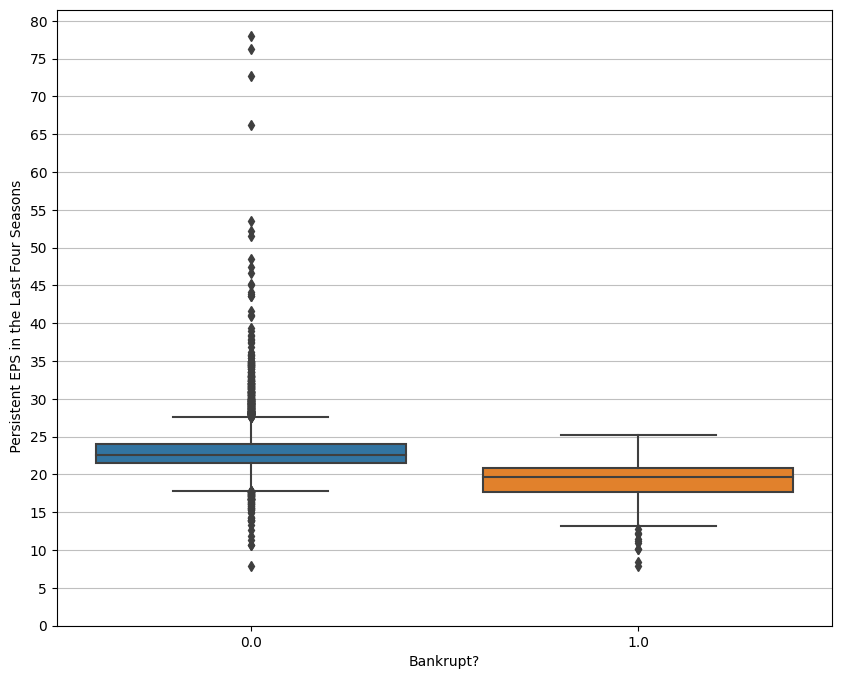

In [48]:
Persistent_EPS = CBP_scaled[(CBP_scaled.iloc[:,19] > 0) & (CBP.iloc[:,19] < 1)].iloc[:,[0,19]]

plt.figure(figsize = (10,8))

graph = sns.boxplot(x = Persistent_EPS['Bankrupt?'], y = Persistent_EPS[' Persistent EPS in the Last Four Seasons'] * 100)
graph.set_axisbelow(True)
graph.set_yticks(np.arange(0,81,5))

plt.grid(axis = 'y', alpha = 0.8)

plt.show()

Los resultados visibles en los graficos nos indica una ligera variacion en la media de cada columna, ademas se puede afrmirar todas las empresas de nuestro dataset que cayeron en bancarrota tenian un EPS menor al 0.27 (27%).

## Retained Earnings to Total Assets

"Retained Earnings to Total Assets" se refiere a la proporción de los "Beneficios Retenidos" en relación con los "Activos Totales" de una empresa. Los "Beneficios Retenidos" son las ganancias acumuladas que una empresa ha decidido retener y reinvertir en lugar de distribuirlos a los accionistas como dividendos. Los "Activos Totales" son el valor total de todos los activos poseídos por la empresa.

Esta medida financiera evalúa la eficiencia y la capacidad de una empresa para utilizar sus beneficios acumulados en comparación con el tamaño de sus activos. Indica la proporción de los activos totales financiados por los beneficios retenidos en lugar de fondos externos o capital accionarial.

Un alto valor puede indicar que la empresa ha acumulado beneficios significativos y ha utilizado esos fondos para expandir y fortalecer su base de activos. Esto puede ser una señal positiva de una gestión financiera sólida y una capacidad para generar ganancias internamente.

Por otro lado, un bajo valor puede indicar que la empresa ha distribuido la mayoría de sus beneficios a los accionistas en lugar de reinvertirlos en la empresa. Esto puede sugerir una menor capacidad de crecimiento interno y dependencia de fuentes externas de financiamiento para expandir sus operaciones.

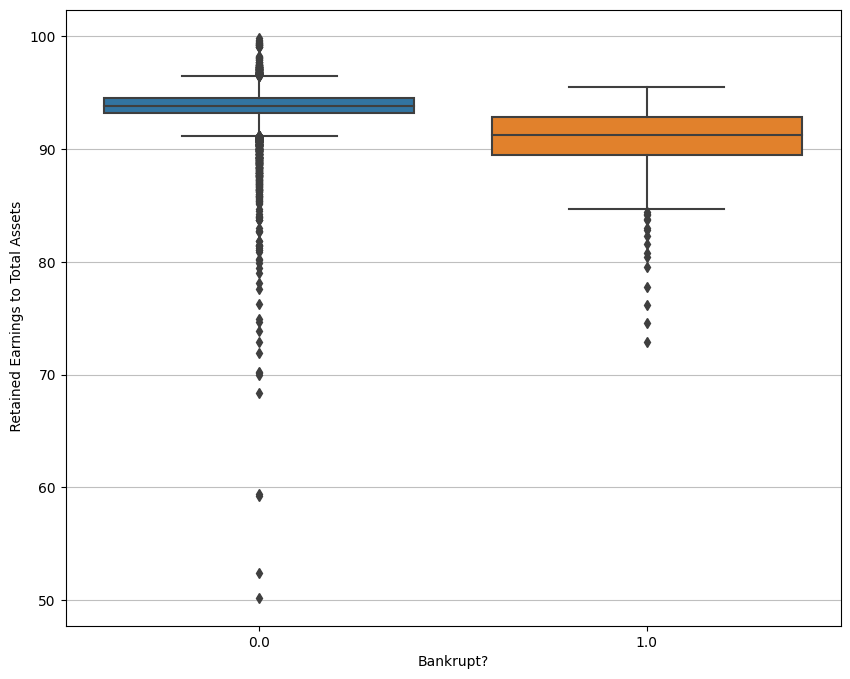

In [51]:
Retained_Earnings = CBP_scaled[(CBP_scaled.iloc[:,68] > 0) & (CBP.iloc[:,68] < 1)].iloc[:,[0,68]]

plt.figure(figsize = (10,8))

graph = sns.boxplot(x = Retained_Earnings['Bankrupt?'], y = Retained_Earnings[' Retained Earnings to Total Assets'] * 100)
graph.set_axisbelow(True)
#graph.set_yticks(np.arange(0,81,5))

plt.grid(axis = 'y', alpha = 0.8)

plt.show()

Se puede observar una clara diferencia en la media entre las companias operativas y las companias en bancarrota, no obstante tambien podemos ver que de la columna de companias operativas tenemos una cantidad alta de outliers que no solo que se superpone con los valores de las companias en bancarrota sino que en algunos casos los sobrepasa, es por esto que **no usaremos este indicador**

## Dataset resultante

In [84]:
CBP_scaled_filtered = CBP_scaled[['Bankrupt?',' Debt ratio %',' Current Liability to Assets',' Net Income to Total Assets',' ROA(A) before interest and % after tax',' Net worth/Assets',' Persistent EPS in the Last Four Seasons']]
CBP_scaled_filtered

,Bankrupt?,Debt ratio %,Current Liability to Assets,Net Income to Total Assets,ROA(A) before interest and % after tax,Net worth/Assets,Persistent EPS in the Last Four Seasons
0,1.0,0.207576,0.147308,0.716845,0.424389,0.792424,0.169141
1,1.0,0.171176,0.056963,0.795297,0.538214,0.828824,0.208944
2,1.0,0.207516,0.098162,0.774670,0.499019,0.792484,0.180581
3,1.0,0.151465,0.098715,0.739555,0.451265,0.848535,0.193722
4,1.0,0.106509,0.110195,0.795016,0.538432,0.893491,0.212537
...,...,...,...,...,...,...,...
6814,0.0,0.124618,0.103838,0.799927,0.539468,0.875382,0.216602
6815,0.0,0.099253,0.089901,0.799748,0.538269,0.900747,0.216697
6816,0.0,0.038939,0.024414,0.797778,0.533744,0.961061,0.210929
6817,0.0,0.086979,0.083199,0.811808,0.559911,0.913021,0.228326


# Etapa 3: Preparacion de los datos

Ya tenemos las 6 variables mas influyentes sobre la bancarrota en nuestro dataset, ahora separemos la variable independiente (Bankrupt?) de las dependientes:

In [85]:
x = CBP_scaled_filtered.iloc[:,1:]
y = CBP_scaled_filtered.iloc[:,0]

## Oversampling / Balanceo de clases
Tenemos dos tipos de clases, companias en bancarrota y operativas, no obstante la muestra de companias operativas en mucho mayor a la de bancarrota, para evistar cualquier tipo de sesgo de nuestro modelo utilizaremos el metodo de oversampling con la libreria de imblearn.

In [90]:
from collections import Counter

# Muestra desbalanceada
count = Counter(y)
count

Counter({0.0: 6599, 1.0: 220})

In [88]:
from imblearn.over_sampling import SMOTE
os = SMOTE()
x_os , y_os = os.fit_resample(x,y)

# Muestra balanceada
count = Counter(y_os)
count

Counter({1.0: 6599, 0.0: 6599})

# Etapa 4: Entrenamiento del modelo predictivo

## Regrecion Logistica
Nuestro dataset nos precenta un problema de clacificaion binaria, asi que para entrenar un modelo de machine learning podemos utilizar el algoritmo de regresion logistica.

In [91]:
# Separacion de datos de prueba y entrenamiento
X_train, X_test , y_train , y_test = train_test_split(x_os , y_os ,test_size = 0.2)

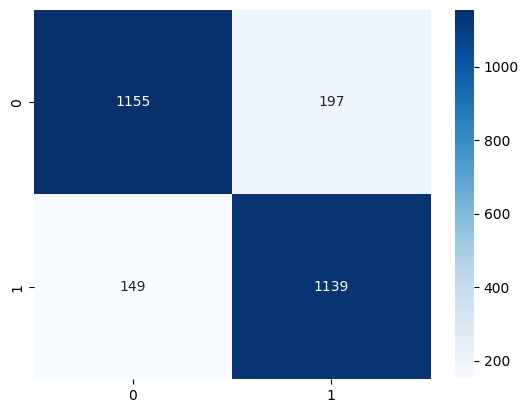

In [92]:
# Entrenamiento
LR = LogisticRegression()
LR.fit(X_train,y_train)

# Prediccion
y_pred = LR.predict(X_test)

# Matriz de confucion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(data = cm, annot = True,cmap='Blues', fmt='g')
plt.show()

## Metricas de validacion
Nuestro modelo es de clacificacion binaria, es decir, solo tenemos dos posibles resultados: empresa en bancarrota u operativa. No obstante, sabemos que no hay un indice economico exacto que nos diga si una empresa va a quebrar o no, de hecho existen empresas cuyos indices son pesimos y aun siguen operativas, y como contraparte, hay empresas que poseían indices "saludables" y entraron en bancarrota. Esto nos lleva a concluir que el entrenamiento de nuestro algoritmo debe estar enfocado a dar la menor cantidad de falsos negativos, pensemoslo de esta manera, si nuesto algoritmo nos dice que una empresa esta cerca de la bancarrota cuando no lo esta, solo tendiramos que abstenernos de invertir en ella y evitariamos cualquier tipo de perdida, quizas tampoco ganariamos, pero en inversiones lo mas importante es no perder. Ahora demos vuelta el caso, si nuestro algoritmo nos dice que una empresa tiene indices lejanos a la bancarrota, y se decide invertir en la misma, tener una lectura errada en esta instancia probocaria la perdida total del dinero invertido.

Es por esto que debemos minimizar los falsos positivos, y para esto debemos lograr la mejor presicion posible.

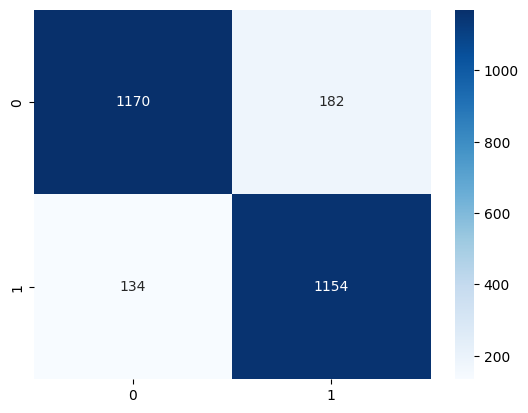

In [93]:
# Entrenamiento refinado
LR_2 = LogisticRegression(penalty = None, max_iter = 1000)
LR_2.fit(X_train,y_train)

# Prediccion 2
y_pred_2 = LR_2.predict(X_test)

# Matriz de confucion
cm_2 = confusion_matrix(y_test, y_pred_2)
sns.heatmap(data = cm_2, annot = True,cmap='Blues', fmt='g')
plt.show()

In [94]:
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

         0.0       0.90      0.87      0.88      1352
         1.0       0.86      0.90      0.88      1288

    accuracy                           0.88      2640
   macro avg       0.88      0.88      0.88      2640
weighted avg       0.88      0.88      0.88      2640



Modificando algunos parametros del algoritmo logramos disminuir los falsos positivos, que son los mas importantes.

# Conclucion
Iniciamos este proyecto con un dataset altamente sobredimencionada y desbalanceado, aplicando diferentes tecnicas de analisis, estadistica y ayudandonos con la programacion logramos redimencionar y balancear el dataset para finalmente poder entrenar un modeo predictivo que nos permite saber cuan cerca esta una empresa de la bancarrota con una presicion del 88%.